#CNN으로 다시 풀어보는 MNIST

In [4]:
#라이브러리 호출
import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim

from torchvision import datasets,transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
#Train, Test 용도 데이터 선택
train_dataset = datasets.MNIST('./mnist_data',
                               download=True,
                               train=True,
                               transform=transforms.ToTensor()
                               )
test_dataset = datasets.MNIST('./mnist_data',
                               download=False,
                               train=False,
                               transform=transforms.ToTensor()
                               )


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [9]:
#데이터셋 로더 호출
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=128,shuffle=True,drop_last=False)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=128,shuffle=False,drop_last=False)


In [10]:
#장치호출
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#CNN 구조도
(1,28,28) -> (6,24,24) -> (6,12,12) -> (16,8,8) -> (16,4,4) -> (16\*4*4) -> (96) -> (10)

pooling으로 가로세로길이 줄이고 2차원 convolutiondmfh 채널이 커지면 담을 수 있는 특성이 많아짐

In [17]:
#Convolutional Neural Network - 모델생성
'''
입력텐서
(batch,1,28,28)

신경망 구조

         커널, 입력채널, 출력채널, 스트라이드, 패딩        출력텐서
Conv     5X5       1         6        1X1       0          (batch,6,24,24) 
Maxpool  2X2                          2X2                  (batch,6,12,12)
Conv     5X5       6         16       1X1       0          (batch,16,8,8)
Maxpool  2X2                          2X2                  (batch,16,4,4)
Flatten                                                    (batch,16*4*4) : 벡터
               입력노드, 출력노드
FC              16*4*4      96                             (batch,96)
dropout                            20% (가중치 행렬의 20%)
FC              96          10                             (batch,10)
'''

class CNN_MNIST(nn.Module):
  def __init__(self):
    super(CNN_MNIST,self).__init__()
    self.conv1 = nn.Conv2d(1,6,5,1)
    self.pool1 = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,16,5,1)
    self.pool2 = nn.MaxPool2d(2,2)
    self.lin1 = nn.Linear(16*4*4,96)
    self.drop1 = nn.Dropout(0.2) #20% 손실을 위함
    self.lin2 = nn.Linear(96,10)

  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = x.view(x.shape[0],-1)  #flatten ->(b,16*4*4)
    x = F.relu(self.drop1(self.lin1(x)))
    x = F.softmax(self.lin2(x))
    return x

In [18]:
#확률간 거리 KL divergence
def kl_div(prob1,prob2):
  '''
  prob1 : label
  prob2 : inference
  '''
  return torch.sum(prob1*torch.log(prob1/prob2+1e-15))

In [21]:
model = CNN_MNIST().to(device)
opt = optim.Adam(model.parameters(),lr=1e-04) #kermel, weight matrix가 학습의 대상

for ep in range(20):
  model.train()
  train_loss = 0
  for X,Y in train_loader: # X(batch,1,28,28) , Y(batch,1) -> (batch,10)
    X = X.to(device)
    Y = Y.to(device)

    #one-hot encoding
    Y_label = torch.zeros((Y.shape[0],10)).to(device)
    Y_label[range(Y.shape[0]),Y]=1

    Y_infer = model(X)
    loss = kl_div(Y_label,Y_infer)
    opt.zero_grad()
    loss.backward()
    opt.step()

    train_loss += loss.item()

#테스트모니터링으로 중간점검
  model.eval()
  test_loss = 0 
  for X,Y in test_loader:
    X = X.to(device)
    Y = Y.to(device)

    Y_label = torch.zeros((Y.shape[0],10)).to(device)
    Y_label[range(Y.shape[0]),Y]=1

    Y_infer = model(X)
    loss = kl_div(Y_label,Y_infer)

    test_loss += loss.item()

  if ep%5==0:
    print('Episode {:d}, Train_loss {:.3f}, Test_loss {:.3f}'
    .format(ep,train_loss/len(train_loader),test_loss/len(test_loader)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Episode 0, Train_loss 180.227, Test_loss 66.778
Episode 5, Train_loss 24.020, Test_loss 17.054
Episode 10, Train_loss 15.138, Test_loss 10.730
Episode 15, Train_loss 11.677, Test_loss 8.351


In [22]:
model.eval()
correct = 0
for X,Y in test_loader:
  X = X.to(device) # 이미지
  Y = Y.to(device) # 실제 레이블
  Y_infer = model(X) # 출력 레이블
  correct += np.mean(torch.argmax(Y_infer,dim=1).detach().cpu().numpy()==Y.detach().cpu().numpy())

print("테스트 데이터 정확도: {:.4f}%"
.format(100.0*correct/len(test_loader)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


테스트 데이터 정확도: 98.2199%


실제 이미지 숫자 7
예측 숫자 7


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


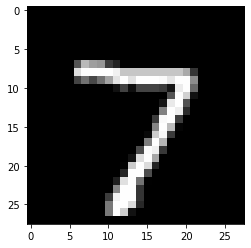

In [23]:
#checking
X,Y = test_dataset[0]
X = X.to(device)
Y_infer = model(torch.unsqueeze(X,0))

print('실제 이미지 숫자',Y)
print('예측 숫자',np.argmax(Y_infer.detach().cpu().numpy()))
plt.imshow(X.detach().cpu().numpy()[0],cmap='gray')